In [1]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

import numpy as np

print(tf.__version__)

2.2.0


## Download the IMDB dataset

In [2]:
(train_data, test_data), info = tfds.load(
    'imdb_reviews/subwords8k',
    split = (tfds.Split.TRAIN, tfds.Split.TEST),
    as_supervised=True,
    with_info=True
)

## Try the encoder

In [3]:
encoder = info.features['text'].encoder

In [4]:
print(f"Vocabulary size: {encoder.vocab_size}")

Vocabulary size: 8185


In [5]:
sample_string = "Hello Tensorflow"

encoded_string = encoder.encode(sample_string)
print(f"Encoded string: {encoded_string}")

original_string = encoder.decode(encoded_string)
print(f"Original string: {original_string}")

Encoded string: [4025, 222, 6307, 2327, 2934]
Original string: Hello Tensorflow


<div class="alert alert-info">
    The encoder encodes the string by breaking it into subwords or characters if the word is <i>not in its dictionary</i>. So the more a string resembles the dataset, the shorter the encoded representation will be.
</div>

In [6]:
for ts in encoded_string:
    print(f"{ts} -------> {encoder.decode([ts])}")

4025 -------> Hell
222 -------> o 
6307 -------> Ten
2327 -------> sor
2934 -------> flow


## Explore the data

The text of reviews have been converted to integers, where each integer represents a specific word-piece in the dictionary.
<br>
<br>
Each label is an integer value of either 0 or 1, where 0 is a negative review, and 1 is a positive review.

In [8]:
for train_example, train_label in train_data.take(1):
    print(f"Encoded example: {train_example[:10].numpy()}")
    print(f"Label: {train_label.numpy()}")

Encoded example: [  62   18   41  604  927   65    3  644 7968   21]
Label: 0


The text data is already preprocessed.

In [9]:
encoder.decode(train_example)

"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."

## Prepare data for training

The reviews are all **different lengths**, so **use padded_batch** to zero pad the sequences while batching.

In [10]:
BUFFER_SIZE = 1000

train_batches = (
    train_data.shuffle(BUFFER_SIZE).padded_batch(32)
)

test_batches = (
    test_data.padded_batch(32)
)

<div class="alert alert-info">
    Each batch will have a shape of <code>(batch_size, sequence_length)</code> because the <b>padding is dynamic</b>, each batch will have a different (sequence)length:
</div>

In [11]:
for example_batch, label_batch in train_batches.take(2):
    print(f"Batch shape: {example_batch.shape}")
    print(f"Label shape: {label_batch.shape}")

Batch shape: (32, 1008)
Label shape: (32,)
Batch shape: (32, 1023)
Label shape: (32,)


Each batch has 32 instances, but the length sequence (after padded) between different batches is different.

## Build the model

<div class="alert alert-danger">
    <b>Caution</b>: This model doesn't use masking, so the zero-padding is used as part of the input, so the padding length may affect the output. To fix this, see the masking and padding guide.
</div>

In [12]:
model = keras.Sequential([
    keras.layers.Embedding(encoder.vocab_size, 16),
    keras.layers.GlobalAveragePooling1D(),
    keras.layers.Dense(1)
])

Here, the `GlobalAveragePooling1D` returns a fixed-length output vector for each example by **averaging over the sequence dimension** (the `Embedding` returns `(batch, sequence, embedding)`). This allows the model to handle input of variable length, in the simplest way possible.

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          130960    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 130,977
Trainable params: 130,977
Non-trainable params: 0
_________________________________________________________________


### Hidden units

### Loss function and optimizer

In [14]:
model.compile(optimizer='adam',
              loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics = ['accuracy'])

## Train the model

**Note**: [validation_steps](https://datascience.stackexchange.com/questions/29719/how-to-set-batch-size-steps-per-epoch-and-validation-steps) 

In [15]:
history = model.fit(train_batches,
                    epochs=10,
                    validation_data=test_batches,
                    validation_steps=30)

Epoch 1/10
782/782 [==============================] - 7s 9ms/step - loss: 0.6822 - accuracy: 0.5005 - val_loss: 0.6643 - val_accuracy: 0.5052
Epoch 2/10
782/782 [==============================] - 7s 8ms/step - loss: 0.6194 - accuracy: 0.5558 - val_loss: 0.5927 - val_accuracy: 0.6104
Epoch 3/10
782/782 [==============================] - 7s 9ms/step - loss: 0.5393 - accuracy: 0.6693 - val_loss: 0.5292 - val_accuracy: 0.7104
Epoch 4/10
782/782 [==============================] - 7s 8ms/step - loss: 0.4721 - accuracy: 0.7537 - val_loss: 0.4804 - val_accuracy: 0.7312
Epoch 5/10
782/782 [==============================] - 7s 9ms/step - loss: 0.4196 - accuracy: 0.8035 - val_loss: 0.4420 - val_accuracy: 0.8031
Epoch 6/10
782/782 [==============================] - 7s 8ms/step - loss: 0.3786 - accuracy: 0.8349 - val_loss: 0.4148 - val_accuracy: 0.8281
Epoch 7/10
782/782 [==============================] - 7s 9ms/step - loss: 0.3471 - accuracy: 0.8546 - val_loss: 0.3961 - val_accuracy: 0.8271
Epoch 

## Evaluate the model

In [16]:
loss, accuracy = model.evaluate(test_batches)

print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

782/782 [==============================] - 3s 4ms/step - loss: 0.3314 - accuracy: 0.8656
Loss: 0.3314041793346405
Accuracy: 0.8656399846076965


## Create a graph of accuracy and loss over time

In [17]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

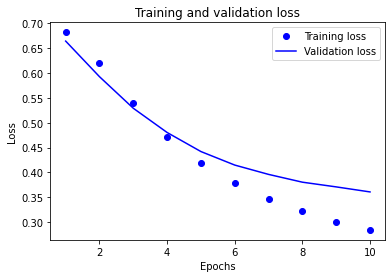

In [18]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

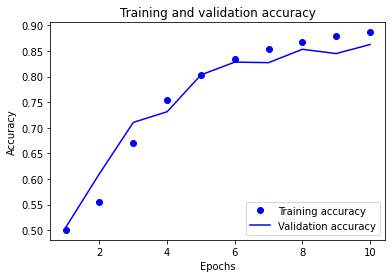

In [19]:
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

## References

- https://www.tensorflow.org/tutorials/keras/text_classification
- https://datascience.stackexchange.com/questions/29719/how-to-set-batch-size-steps-per-epoch-and-validation-steps